# Random sampling and Monte Carlo methods

Authors: Maya Fishbach, adapted from Carl Haster

In [1]:
import numpy as np

import matplotlib 
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (5, 3)
import matplotlib.pyplot as plt

from scipy.integrate import cumulative_trapezoid as cumtrapz

## Why samples?

* maximum likelihood is not enough for many applications, especially in high dimensions
  * the probability contained in a given region of parameter space is the probability density $\times$ volume
  * the volume can be very large away from the maximum likelihood or maximum a posteriori
* samples allow us to compute expectation values ("Monte Carlo integrals")
  * moments of the distribution (mean, variance, etc.)
* map out the probability distribution, find correlations, etc.
  * sampling from the distribution can be much cheaper than evaluating the likelihood on a high-dimensional grid!

## Drawing samples from a PDF

* pseudo-random number generators
* Given a (pseudo)-random number from a known distribution, transform to a different distribution via:
  * inverse transform sampling
  * rejection sampling

### Psuedo-random number generators

Computers are deterministic. A pseudo-random number generator uses some formula whose outcome depends sensitively on the input, then iterate.

Note: Need starting point for the iteration (random number seed), but that makes the result reproducible (good for testing and debugging).

A popular pseudo-random number generator is a [linear congruential generator](https://en.m.wikipedia.org/wiki/Linear_congruential_generator). Such a generator is implemented below.

In [2]:
def my_rng(m=2**32, a=1103515245, b=12345):
    """Generate a sequence of (pseudo-)random numbers from a uniform distribution.
    This function updates a given (pseudo-)random number to a new one.
    """
    my_rng.current = (a*my_rng.current + b) % m
    return my_rng.current/m

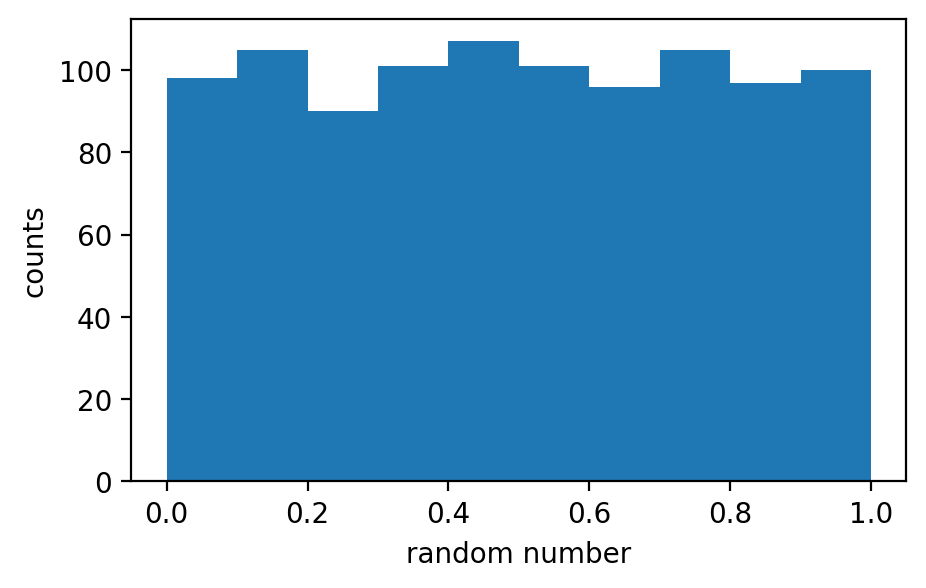

In [3]:
my_rng.current = 239485821 #setting the random number seed
random_numbers = np.array([my_rng() for i in range(1000)]) #Draw a 1000 random numbers
plt.hist(random_numbers,range=(0.,1.),bins=10) #plot a histogram
plt.xlabel("random number")
plt.ylabel("counts")
plt.show()

In numpy, this is implemented in the [numpy.random](https://numpy.org/doc/stable/reference/random/index.html) module. 

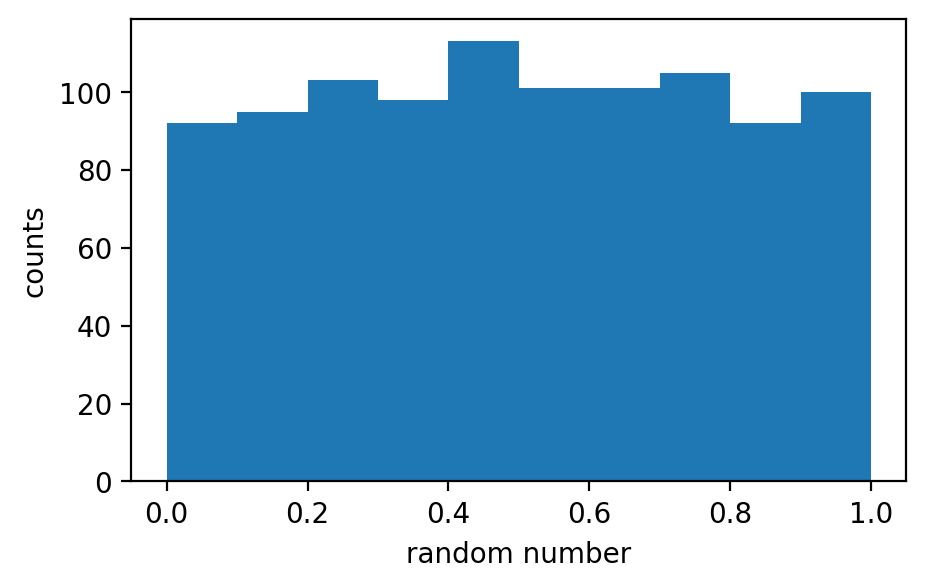

In [4]:
rng = np.random.default_rng(seed = 123)
# Generate 1000 random floats uniformly distributed over the range [0, 1)
random_uniform = rng.random(1000) 
plt.hist(random_uniform,range=(0.,1.),bins=10) #plot a histogram
plt.xlabel("random number")
plt.ylabel("counts")
plt.show()

### Inverse transform sampling

If we can draw random numbers from a uniform distribution, we can draw from any distribution as long as we can calculate its CDF. 

* Calculate cumulative probability distribution (CDF): $\mathrm{CDF}(x) = \int_{-\infty}^x \mathrm{d}x' P(x)$
* invert that function to get the inverse cumulative probability distribution (iCDF) such that if y = CDF(x), iCDF(y) = x
* draw random values $y$ between 0 and 1
* evaluate $\mathrm{iCDF}(y)$ to find values of $x$ following the distribution $P(x)$

For example, we can take our uniformly distributed random numbers and transform them to a set of random draws from a Gaussian distribution.

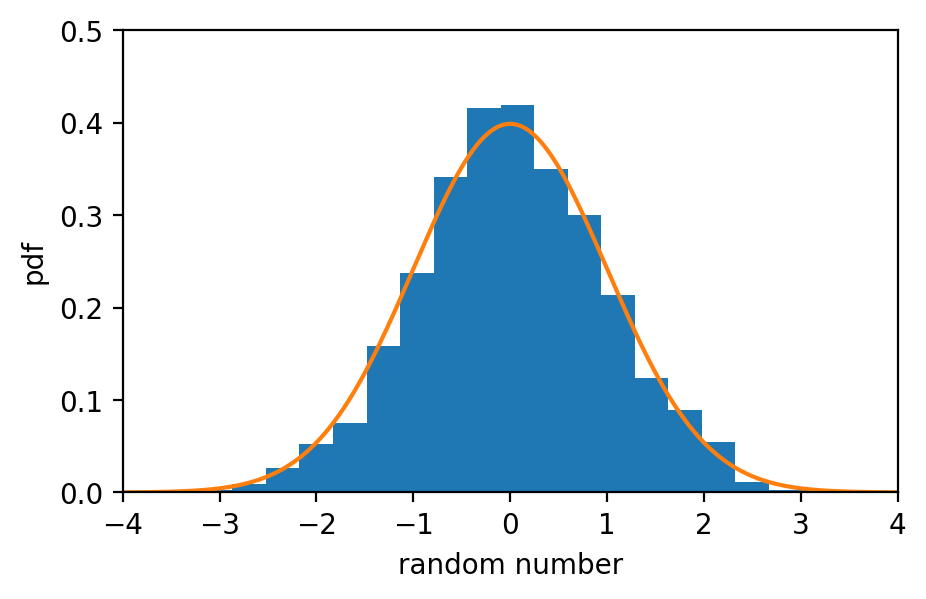

In [14]:
def Gaussian_pdf(x, mu = 0, sigma = 1):

    return np.exp(-(x-mu)**2/(2*sigma**2)) * (2*np.pi*sigma**2)**-0.5

#the Gaussian cdf is known analytically, but for other distributions we may have to numerically integrate

xs = np.linspace(-5,5,1000) #define array; +/- 5 sigma should capture almost 100% of the probability
pdf_xs = Gaussian_pdf(xs) #evaluate Gaussian pdf on array 
cdf_xs = cumtrapz(pdf_xs, xs, initial = 0) #take the cumulative integral of the pdf to calculate the cdf
inv_cdf = lambda y: np.interp(y, cdf_xs, xs) #calculate the inverse function of the cdf; for any number y between 0 and 1, return iCDF(y)

#transform our 1000 draws from a uniform distribution (saved in random_uniform array)
random_normal_its = inv_cdf(random_uniform)

#plot 
plt.hist(random_normal_its,bins=20, density = True) #plot a histogram
plt.plot(xs, pdf_xs)
plt.xlim(-4,4)
plt.ylim(0,0.5)

plt.xlabel('random number')
plt.ylabel('pdf')

plt.show()

Numpy already has a built in function to draw from a Gaussian distribution:

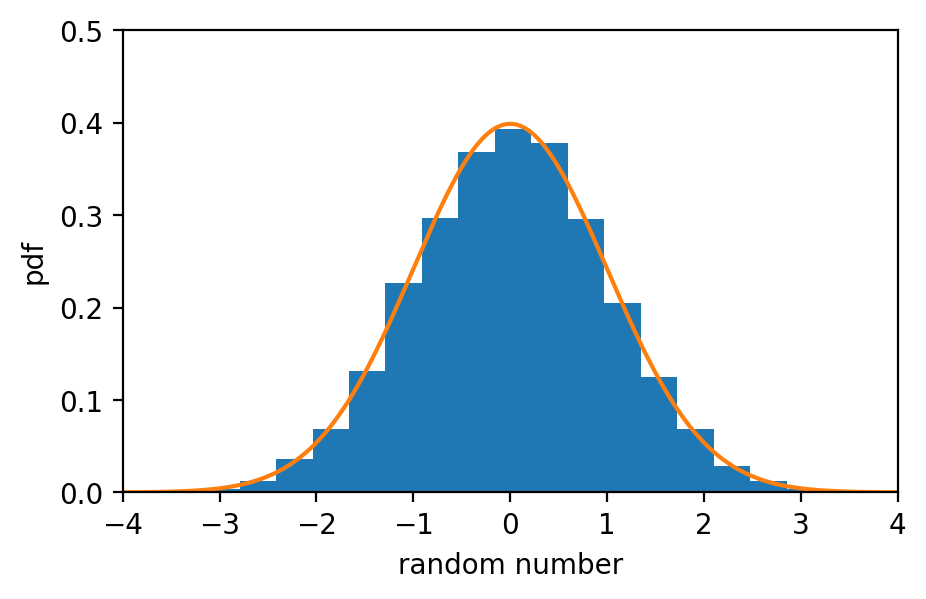

In [15]:
# Generate an array of 1000 random floats drawn from a standard normal (Gaussian) distribution
rng = np.random.default_rng(seed = 123)
random_normal_np = rng.standard_normal(10000) 

plt.hist(random_normal_np,bins=20, density = True) #plot a histogram

plt.plot(xs, pdf_xs) #plot analytic pdf

plt.xlim(-4, 4)
plt.ylim(0, 0.5)

plt.xlabel("random number")
plt.ylabel("pdf")
plt.show()

## Rejection sampling

In more than one dimension, there is no well-defined cumulative distribution function. Thus, we have to come up with a new idea:

* Sample (some region of) N-dimensional space following a simple PDF $Q(x)$ (we will use a uniform distribution).
* Add an acceptance-rejection step that accepts the sample $x$ with probability $P(x)/(c\ Q(x))$.
* Choose $c$ such that $P(x) < c\ Q(x)$ for all $x$ (but ideally not too large).

We will use a two-dimensional Gaussian in this example.